In [1]:
import sqlite3
def list_tables(database_file):
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    cursor.execute("""select name from sqlite_master where type = 'table';
                    """)
                    
    tables = cursor.fetchall()
    cursor.close()
    connection.close()
    table_names = [table[0] for table in tables]
    return table_names




In [2]:
import pandas as pd
connection = sqlite3.connect('data.db')
query = """select *
        from client as cl;
        """
client = pd.read_sql_query(query, connection)
connection.close

<function Connection.close()>

In [3]:
import pandas as pd
connection = sqlite3.connect('data.db')
query = """select *
        from client_products as cl;
        """
client_products = pd.read_sql_query(query, connection)
connection.close

<function Connection.close()>

In [4]:
import pandas as pd
connection = sqlite3.connect('data.db')
query = """select *
        from balances as cl;
        """
balances = pd.read_sql_query(query, connection)
connection.close

<function Connection.close()>

In [5]:
import pandas as pd
connection = sqlite3.connect('data.db')
query = """select *
        from inv_campaign_eval as cl;
        """
inv_campaign_eval = pd.read_sql_query(query, connection)
connection.close

<function Connection.close()>

In [6]:
connection = sqlite3.connect('data.db')
query = """
        select *
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id
        --left join balances as ba on cl.client_id = ba.client_id
        --left join inv_campaign_eval as camp on cl.client_id = camp.client_id;
        """
clients_merged = pd.read_sql_query(query, connection)
connection.close

<function Connection.close()>

In [7]:
my_database_file_path = "/content/data.db"

In [8]:

print(client.head(10))
print(client_products.head(10))
print(balances.head(10))
print(inv_campaign_eval.head(10))
print(clients_merged.head(10))

    client_id   age            job   marital  education gender
0   249789938  38.0       services   married  secondary      M
1  1222646323  46.0       services  divorced    unknown      M
2   451375919  33.0         admin.    single  secondary      F
3   338972671  44.0  self-employed   married  secondary      F
4  1472834688  36.0    blue-collar   married    primary      M
5  1068680340  63.0         admin.   married  secondary      F
6   711558356  38.0  self-employed    single   tertiary      F
7   422084751  30.0     technician    single  secondary      M
8   123316323  36.0    blue-collar  divorced  secondary      F
9  1504633819  38.0     management   married   tertiary      M
    client_id has_deposits loan has_insurance has_mortgage
0   249789938          yes   no             n           no
1  1222646323           no   no             n           no
2   451375919           no   no             n          yes
3   338972671           no   no             y          yes
4  147283468

In [9]:
clients_merged

,client_id,age,job,marital,education,gender,client_id,has_deposits,loan,has_insurance,has_mortgage
0,249789938,38.0,services,married,secondary,M,249789938,yes,no,n,no
1,1222646323,46.0,services,divorced,unknown,M,1222646323,no,no,n,no
2,451375919,33.0,admin.,single,secondary,F,451375919,no,no,n,yes
3,338972671,44.0,self-employed,married,secondary,F,338972671,no,no,y,yes
4,1472834688,36.0,blue-collar,married,primary,M,1472834688,yes,no,n,yes
...,...,...,...,...,...,...,...,...,...,...,...
11157,543198889,40.0,blue-collar,single,unknown,M,543198889,no,no,n,yes
11158,458558558,41.0,housemaid,divorced,primary,F,458558558,no,no,n,yes
11159,1426334329,59.0,technician,married,primary,F,1426334329,no,no,y,yes
11160,831035343,42.0,management,married,tertiary,M,831035343,no,no,n,no


In [10]:
clients_merged.isnull().sum()

client_id          0
age              232
job              438
marital            0
education          0
gender             0
client_id          0
has_deposits       0
loan               0
has_insurance      0
has_mortgage       0
dtype: int64

In [11]:
clients_merged.dtypes

client_id          int64
age              float64
job               object
marital           object
education         object
gender            object
client_id          int64
has_deposits      object
loan              object
has_insurance     object
has_mortgage      object
dtype: object

/var/folders/58/jt8r497132q6cyg8d_4hrs7r0000gn/T/ipykernel_88378/4137032966.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=clients_merged, x='marital', palette='viridis')


Text(0.5, 1.0, 'Survival Rate by Sex')

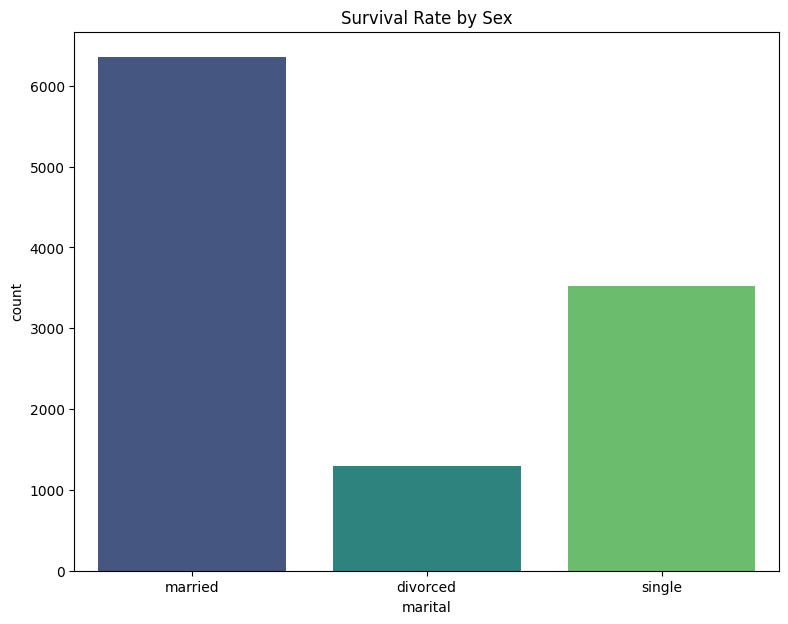

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.figure(figsize=(20, 7))

# Survival rate by Sex
plt.subplot(1, 2, 1)
sns.countplot(data=clients_merged, x='marital', palette='viridis')
plt.title('Survival Rate by Sex')

In [13]:
from sklearn.preprocessing import LabelEncoder
# Applying Label Encoding
le = LabelEncoder()
clients_merged['has_deposits'] = le.fit_transform(clients_merged['has_deposits'])
clients_merged['loan'] = le.fit_transform(clients_merged['loan'])
clients_merged['has_insurance'] = le.fit_transform(clients_merged['has_insurance'])
clients_merged['has_mortgage'] = le.fit_transform(clients_merged['has_mortgage'])
clients_merged['marital'] = le.fit_transform(clients_merged['marital'])
clients_merged['education'] = le.fit_transform(clients_merged['education'])
clients_merged['gender'] = le.fit_transform(clients_merged['gender'])
clients_merged['job'] = clients_merged['job'].fillna('unknown')
clients_merged['job'] = le.fit_transform(clients_merged['job'])
clients_merged['age'].fillna(clients_merged['age'].median(), inplace=True)
print(clients_merged.head())

    client_id   age  job  marital  education  gender   client_id  \
0   249789938  38.0    7        1          1       1   249789938   
1  1222646323  46.0    7        0          3       1  1222646323   
2   451375919  33.0    0        2          1       0   451375919   
3   338972671  44.0    6        1          1       0   338972671   
4  1472834688  36.0    1        1          0       1  1472834688   

   has_deposits  loan  has_insurance  has_mortgage  
0             1     0              0             0  
1             0     0              0             0  
2             0     0              0             1  
3             0     0              1             1  
4             1     0              0             1  


In [14]:
clients_merged.isnull().sum()

client_id        0
age              0
job              0
marital          0
education        0
gender           0
client_id        0
has_deposits     0
loan             0
has_insurance    0
has_mortgage     0
dtype: int64

In [15]:
fig = px.histogram(clients_merged, x="gender", y="age",
             color='education', barmode='group',
             height=400)
fig.show()

In [16]:
fig = px.pie(clients_merged, values='has_mortgage', names='gender')
fig.show()

In [18]:
# Assuming df is your DataFrame with columns 'client_id' and 'timestamp'
# Make sure 'timestamp' is in datetime format
balances['date'] = pd.to_datetime(balances['date'])

# Get the index of the last timestamp for each client_id
last_timestamp_index = balances.groupby('client_id')['date'].idxmax()
last_timestamp_indexx = balances.groupby('client_id')['balance'].idxmin()

# Use the index to extract the corresponding rows from the original DataFrame
last_timestamp_df = balances.loc[last_timestamp_index]
last_timestamp_dff = balances.loc[last_timestamp_indexx]
# Display the DataFrame with the last timestamp for each client_id
print(last_timestamp_df,last_timestamp_dff)

                             date      balance   client_id currency
265876 2023-06-06 16:22:36.643827   175.445269   100070076      CZK
175292 2023-06-06 16:22:04.265177  2559.041192   100141910      CZK
191620 2023-06-06 16:22:09.249972    94.055761   100207570      CZK
43680  2023-06-06 16:21:25.597087   382.755389   100488560      CZK
262678 2023-06-06 16:22:35.410449   369.476219   100605013      CZK
...                           ...          ...         ...      ...
22854  2023-06-06 16:21:20.742835  1146.101785  1999463182      CZK
130338 2023-06-06 16:21:50.781726    30.830676  1999499145      CZK
87074  2023-06-06 16:21:36.964752   792.767525  1999715381      CZK
89154  2023-06-06 16:21:37.470159  5077.753230  1999945413      CZK
232674 2023-06-06 16:22:24.006798   229.440915  1999956516      CZK

[11162 rows x 4 columns]                              date      balance   client_id currency
265895 2022-09-13 16:22:36.643827   103.460451   100070076      CZK
175302 2023-01-17 16:2

In [19]:
from forex_python.converter import CurrencyRates
import datetime
from forex_python.converter import RatesNotAvailableError

# Create a CurrencyRates object
c = CurrencyRates()


# EUR
# Specify the currencies and the date range
base_currency = 'EUR'
target_currency = 'CZK'
start_date = datetime.date(2022, 6, 21)
end_date = datetime.date(2023, 6, 6)

# Get historical exchange rates within the specified date range
eur_rates = {}


current_date = start_date
while current_date <= end_date:
    try:
        rate = c.get_rate(base_currency, target_currency, current_date)
        eur_rates[current_date] = rate
    except RatesNotAvailableError as e:
        print(e)  # Print the error message
        # Handle the error as needed
        # For example, you can skip this date and continue with the next one

    current_date += datetime.timedelta(days=1)

# Print the historical rates
for date, rate in eur_rates.items():
    print(f"{date}: {rate}")


# USD

base_currency = 'USD'
target_currency = 'CZK'
start_date = datetime.date(2022, 6, 21)
end_date = datetime.date(2023, 6, 6)

# Get historical exchange rates within the specified date range
usd_rates = {}


current_date = start_date
while current_date <= end_date:
    try:
        rate = c.get_rate(base_currency, target_currency, current_date)
        usd_rates[current_date] = rate
    except RatesNotAvailableError as e:
        print(e)  # Print the error message
        # Handle the error as needed
        # For example, you can skip this date and continue with the next one

    current_date += datetime.timedelta(days=1)

# Print the historical rates
for date, rate in usd_rates.items():
    print(f"{date}: {rate}")
    



2022-06-21: 24.69
2022-06-22: 24.712
2022-06-23: 24.75
2022-06-24: 24.731
2022-06-25: 24.731
2022-06-26: 24.731
2022-06-27: 24.724
2022-06-28: 24.726
2022-06-29: 24.739
2022-06-30: 24.739
2022-07-01: 24.753
2022-07-02: 24.753
2022-07-03: 24.753
2022-07-04: 24.745
2022-07-05: 24.751
2022-07-06: 24.778
2022-07-07: 24.779
2022-07-08: 24.614
2022-07-09: 24.614
2022-07-10: 24.614
2022-07-11: 24.592
2022-07-12: 24.582
2022-07-13: 24.397
2022-07-14: 24.417
2022-07-15: 24.561
2022-07-16: 24.561
2022-07-17: 24.561
2022-07-18: 24.508
2022-07-19: 24.555
2022-07-20: 24.493
2022-07-21: 24.496
2022-07-22: 24.514
2022-07-23: 24.514
2022-07-24: 24.514
2022-07-25: 24.535
2022-07-26: 24.607
2022-07-27: 24.575
2022-07-28: 24.609
2022-07-29: 24.61
2022-07-30: 24.61
2022-07-31: 24.61
2022-08-01: 24.628
2022-08-02: 24.644
2022-08-03: 24.65
2022-08-04: 24.659
2022-08-05: 24.581
2022-08-06: 24.581
2022-08-07: 24.581
2022-08-08: 24.515
2022-08-09: 24.532
2022-08-10: 24.397
2022-08-11: 24.346
2022-08-12: 24.38


In [20]:
# Convert the dictionary to a DataFrame
df_eur = pd.DataFrame(list(eur_rates.items()), columns=['Date', 'ExchangeRate'])
df_usd = pd.DataFrame(list(usd_rates.items()), columns=['Date', 'ExchangeRate'])

# Print the DataFrame
df_eur

,Date,ExchangeRate
0,2022-06-21,24.690
1,2022-06-22,24.712
2,2022-06-23,24.750
3,2022-06-24,24.731
4,2022-06-25,24.731
...,...,...
346,2023-06-02,23.657
347,2023-06-03,23.657
348,2023-06-04,23.657
349,2023-06-05,23.573


In [21]:
df_usd

,Date,ExchangeRate
0,2022-06-21,23.402844
1,2022-06-22,23.488262
2,2022-06-23,23.587153
3,2022-06-24,23.499620
4,2022-06-25,23.499620
...,...,...
346,2023-06-02,21.979931
347,2023-06-03,21.979931
348,2023-06-04,21.979931
349,2023-06-05,22.051450


In [28]:
balances['date'] = pd.to_datetime(balances['date']).dt.date
balances

,date,balance,client_id,currency
0,2023-06-06,2680.467773,249789938,CZK
1,2023-05-23,2654.055419,249789938,CZK
2,2023-05-09,2620.835872,249789938,CZK
3,2023-04-25,2720.315925,249789938,CZK
4,2023-04-11,2687.601982,249789938,CZK
...,...,...,...,...
290207,2022-08-16,145.454161,705801685,CZK
290208,2022-08-02,-5.497494,705801685,CZK
290209,2022-07-19,-45.891607,705801685,CZK
290210,2022-07-05,19.473946,705801685,CZK


In [37]:
df_usd

,Date,ExchangeRate
0,2022-06-21,23.402844
1,2022-06-22,23.488262
2,2022-06-23,23.587153
3,2022-06-24,23.499620
4,2022-06-25,23.499620
...,...,...
346,2023-06-02,21.979931
347,2023-06-03,21.979931
348,2023-06-04,21.979931
349,2023-06-05,22.051450


In [50]:
df_eur['date'] = pd.to_datetime(df_eur['Date']).dt.date
df_eur

,Date,ExchangeRate,date
0,2022-06-21,24.690,2022-06-21
1,2022-06-22,24.712,2022-06-22
2,2022-06-23,24.750,2022-06-23
3,2022-06-24,24.731,2022-06-24
4,2022-06-25,24.731,2022-06-25
...,...,...,...
346,2023-06-02,23.657,2023-06-02
347,2023-06-03,23.657,2023-06-03
348,2023-06-04,23.657,2023-06-04
349,2023-06-05,23.573,2023-06-05


In [51]:

merged_df = pd.merge(balances, df_eur, on='date', how='left')

# Print the resulting merged DataFrame
print(merged_df)

              date      balance  client_id currency        Date  ExchangeRate
0       2023-06-06  2680.467773  249789938      CZK  2023-06-06        23.520
1       2023-05-23  2654.055419  249789938      CZK  2023-05-23        23.681
2       2023-05-09  2620.835872  249789938      CZK  2023-05-09        23.363
3       2023-04-25  2720.315925  249789938      CZK  2023-04-25        23.476
4       2023-04-11  2687.601982  249789938      CZK  2023-04-11        23.469
...            ...          ...        ...      ...         ...           ...
290207  2022-08-16   145.454161  705801685      CZK  2022-08-16        24.540
290208  2022-08-02    -5.497494  705801685      CZK  2022-08-02        24.644
290209  2022-07-19   -45.891607  705801685      CZK  2022-07-19        24.555
290210  2022-07-05    19.473946  705801685      CZK  2022-07-05        24.751
290211  2022-06-21   163.032053  705801685      CZK  2022-06-21        24.690

[290212 rows x 6 columns]


In [52]:
# Filter rows where 'currency' is 'EUR'
eur_df = merged_df[merged_df['currency'] == 'EUR']

# Multiply 'ExchangeRate' with 'balance' and create a new column 'result'
eur_df['result'] = eur_df['ExchangeRate'] * eur_df['balance']
eur_df


/var/folders/58/jt8r497132q6cyg8d_4hrs7r0000gn/T/ipykernel_88378/2149892409.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,balance,client_id,currency,Date,ExchangeRate,result
14170,2023-06-06,10.360833,1271406253,EUR,2023-06-06,23.520,243.686783
14171,2023-05-23,13.817896,1271406253,EUR,2023-05-23,23.681,327.221588
14172,2023-05-09,12.363607,1271406253,EUR,2023-05-09,23.363,288.850959
14173,2023-04-25,11.285387,1271406253,EUR,2023-04-25,23.476,264.935751
14174,2023-04-11,9.346319,1271406253,EUR,2023-04-11,23.469,219.348755
...,...,...,...,...,...,...,...
286775,2022-08-16,85.520572,991451828,EUR,2022-08-16,24.540,2098.674827
286776,2022-08-02,85.062451,991451828,EUR,2022-08-02,24.644,2096.279042
286777,2022-07-19,84.893426,991451828,EUR,2022-07-19,24.555,2084.558072
286778,2022-07-05,85.540004,991451828,EUR,2022-07-05,24.751,2117.200635


In [ ]:
balances_mean = pd.DataFrame(balances)

# Convert 'date' to datetime format
balances['date'] = pd.to_datetime(balances['date'])

# Group by 'client_id' and calculate the mean balance for each client
mean_balance_by_client = balances.groupby('client_id')['balance'].mean().reset_index()

# Display the resulting DataFrame with mean balances
print(mean_balance_by_client)